In [1]:
from Library import *
from Data_Preparation import *
#from Data_Preparation2 import *
from pprint import pprint
import folium 
import time
import scipy
import sklearn
from IPython.display import display
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
import pickle
from sklearn import decomposition
from icecream import ic 
import os
from tqdm import tqdm
import requests
import nbimporter
from datetime import datetime
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_curve, auc , roc_auc_score, r2_score, accuracy_score , silhouette_score
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
import reverse_geocoder as rg
from datetime import datetime, time
import random
import shutil
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cluster import DBSCAN
from IPython.display import Markdown, display
import geopandas as gpd
from translate import translator
from shapely.geometry import Point
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [2]:
def speed_estimation(trip_record):
    """
    Estimate the speed with the GPS points and calculate some statistical measures of the estimation.
    :param trip_record: data frame with the original GPS meta-data
    :return: trip_record data frame with new columns - prev_time, prev_latitude, prev_longitude
    """
    trip_record['prev_time'] = trip_record['orig_time'].shift(1)
    trip_record['prev_latitude'] = trip_record['latitude'].shift(1)
    trip_record['prev_longitude'] = trip_record['longitude'].shift(1)
    trip_record['speed'] = trip_record.apply(lambda row: haversine(row['prev_longitude'], row['prev_latitude'],
                                                                       row['longitude'], row['latitude']) /
                                                             ((row['orig_time']-row['prev_time']).seconds/(60*60)),
                                                 axis=1)
#     pearson_corr, p_value = pearsonr(trip_record['speed_est'].iloc[1:], trip_record['speed'].iloc[1:])
#     plt.plot(trip_record['orig_time'], trip_record['speed_est'])
#     plt.plot(trip_record['orig_time'], trip_record['speed'])
#     plt.show()
    return trip_record


def acceleration_estimation(trip_record):
    """
    Estimate the acceleration with the speed data.
    :param trip_record: data frame with the original GPS meta-data
    :return: trip_record data frame with new columns - prev_time, next_time, prev_speed, next_speed,
                acceleration_est_1/2/3
    """
    trip_record['orig_time'] = pd.to_datetime(trip_record['orig_time'])
    trip_record['prev_time'] = trip_record['orig_time'].shift(1)
    trip_record['next_time'] = trip_record['orig_time'].shift(-1)
    trip_record['prev_time'] = pd.to_datetime(trip_record['prev_time'])
    trip_record['next_time'] = pd.to_datetime(trip_record['next_time'])
    trip_record['prev_speed'] = trip_record['speed'].shift(1)
    trip_record['next_speed'] = trip_record['speed'].shift(-1)
    trip_record = trip_record.copy().loc[~(trip_record['next_time'] == trip_record['prev_time'])]
    trip_record['acceleration_est_1'] = trip_record.apply(lambda row: (row['next_speed'] - row['prev_speed']) /
                                                                      (row['next_time'] - row['prev_time']).seconds
                                                          , axis=1)
    trip_record.at[trip_record.index[0], 'acceleration_est_1'] = (trip_record['next_speed'].iloc[0] -
                                                                  trip_record['speed'].iloc[0]) / \
                                                                 (trip_record['next_time'].iloc[0] -
                                                                  trip_record['orig_time'].iloc[0]).seconds
    trip_record.at[trip_record.index[-1], 'acceleration_est_1'] = (trip_record['speed'].iloc[-1] -
                                                                   trip_record['prev_speed'].iloc[-1]) / \
                                                                  (trip_record['orig_time'].iloc[-1]
                                                                   - trip_record['prev_time'].iloc[-1]).seconds
    """trip_record['acceleration_est_2'] = trip_record.apply(lambda row: (row['speed'] - row['prev_speed']) /
                                                                      (row['orig_time'] - row['prev_time']).seconds,
                                                          axis=1)
    trip_record['acceleration_est_3'] = trip_record.apply(lambda row: (row['next_speed'] - row['speed']) /
                                                                      (row['next_time'] - row['orig_time']).seconds
                                                          , axis=1)"""
    return trip_record


def angular_acc_estimation(trip_record):
    """
    create the angular acc estimation
    :param trip_record: data frame having the shifted columns from the acceleration estimation function.
    :return: 3 new columns to the trip data frame - prev direction, next direction, and angular acc.
    """
    # trip_no_idle = trip_record.copy()
    trip_record = trip_record.copy().loc[~((trip_record['orig_time'] == trip_record['prev_time']) |
                                           (trip_record['orig_time'] == trip_record['next_time']))]
    trip_record['prev_direction'] = trip_record.direction.shift(1)
    trip_record['next_direction'] = trip_record.direction.shift(-1)
    # trip_record['prev_time'] = trip_record.orig_time.shift(1)
    # trip_record['next_time'] = trip_record.orig_time.shift(-1)
    trip_record = trip_record.copy().loc[~(trip_record['next_time'] == trip_record['prev_time'])]
    
 
    # Calculate angular acceleration
    trip_record['angular_acc'] = trip_record.apply(lambda row:
                                                   (row['next_direction'] - 2 * row['direction'] + row['prev_direction']) /
                                                   ((row['next_time'] - row['orig_time']).total_seconds() * 
                                                    (row['orig_time'] - row['prev_time']).total_seconds()), axis=1)
    
    return trip_record



In [3]:
def trip_on_map(df):
    # Create a map object
    m = folium.Map(location=[0, 0], zoom_start=2)

    # Define colors for markers
    colors = {2: 'green', 0: 'blue', 1: 'red', 3: 'orange', 4: 'pink', 5: 'teal', 6: 'maroon', 7: 'lavender'}

    color = colors[0]
    j = 0 


    for i, row in df.iterrows():
        if row['speed'] == 0:
            color = colors[1]
            rad = 8
        else:
            color = colors[0]
            rad = 5
        lat, lon = row['latitude'], row['longitude']
        folium.CircleMarker(location=[lat, lon], radius=rad, color=color, fill=True, fill_color=color).add_to(m)

    # Display the map
    return m

In [4]:
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore')

In [5]:
all_trips = []
for year in ['2018','2019']:
        for month in range(1,13,1): 

            with open(f"/bigdata/users-home/dor/transpotation research/agg_data/preprocessGlobalFeatures/{str(month)}_{year}_[460631]_trips.pickle", 'rb') as handle:
                    trips_lst = pickle.load(handle)
            for trip in trips_lst[0]:
                
                trip.time_series_record.drop_duplicates(subset=['orig_time'], keep=False)
#                 curr_trip = speed_estimation(trip.time_series_record)
                curr_trip = acceleration_estimation(trip.time_series_record)
                curr_trip =angular_acc_estimation(curr_trip)
                curr_trip = curr_trip[(curr_trip['vehicle_state'] == 1) | (curr_trip['vehicle_state'] == 2)]
                curr_trip['date'] = curr_trip['orig_time'].dt.date
                curr_trip['hour'] = curr_trip['orig_time'].dt.time
                curr_trip['drive_id'] = trip.id
                
                curr_trip.drop(['prev_time',
                       'next_time','prev_speed','next_speed','prev_direction',
                      'next_direction','mileage','vehicle_id'],axis=1,inplace=True)
                curr_trip.fillna(0, inplace=True)
                all_trips.append(curr_trip)
print(len(all_trips))

2711


In [6]:
file_path = "/bigdata/users-home/dor/transpotation research/agg_data/grouped_drives.pickle"

# Read the pickle file
with open(file_path, 'rb') as handle:
    dict_drives = pickle.load(handle)

# Now you can use the dictionary stored in dict_drives
# For example, print the keys of the dictionary
print(dict_drives.keys())

dict_keys([1, 2, 3, 5, 6, 4])


In [7]:
drives_lst = [list(dict_drives[group].index) for group in dict_drives]

In [8]:
min_df = 0
minimum = 180
lengths = []
filtered_trips = [series for series in all_trips if (len(series) > 70 and len(series) < 300)  and (np.max(series.speed)>0 or np.max(series.vehicle_state)<2)]
print('the amount of filtered drives:',len(filtered_trips))
for series in filtered_trips:
    len_cur = len(series)
    lengths.append(len_cur)
    if len_cur < minimum:
        minimum = len_cur
        min_df = series

the amount of filtered drives: 2220


In [9]:
ts_drives = []
for trip in filtered_trips:
    for ind in drives_lst:
        if np.mean(trip.drive_id) in ind:
#             new_index = pd.date_range(start, end, freq='0.5min')
            trip['speed'] = round(trip['speed'],0)
            ts_drives.append(trip)
print(len(ts_drives))

754


In [10]:
groups_ts = {}

for group in dict_drives:
    for ind , row in dict_drives[group].iterrows():
        for series in ts_drives:
            if np.mean(series.drive_id) == ind:
                groups_ts[group] = groups_ts.get(group , [])
                groups_ts[group].append(series)
                break


In [79]:
import folium
import pandas as pd

def plot_drives_from_dfs(dfs, lat_col='latitude', lon_col='longitude', start_location=(0, 0), zoom_start=12, map_filename="drives_map.html"):
    """
    Function to plot drives on a map with lines based on the DataFrames provided.

    Args:
        dfs (list): List of DataFrames, where each DataFrame contains longitude and latitude columns representing a drive.
        lat_col (str): The column name for latitude in the DataFrame.
        lon_col (str): The column name for longitude in the DataFrame.
        start_location (tuple): Initial center of the map, default is (0, 0).
        zoom_start (int): Initial zoom level for the map.
        map_filename (str): The name of the HTML file to save the map to.
    """
    # Create a map centered at start_location
    map_drives = folium.Map(location=start_location, zoom_start=zoom_start)

    # Loop through each DataFrame (drive) and plot it on the map
    for df in dfs:
        # Extract the latitudes and longitudes from the DataFrame
        coordinates = list(zip(df[lat_col], df[lon_col]))

        # Add a line connecting the coordinates from the drive
        folium.PolyLine(coordinates, color="blue", weight=2.5, opacity=1).add_to(map_drives)

        # Add start and end markers for the drive
        folium.Marker(location=coordinates[0], popup="Start").add_to(map_drives)
        folium.Marker(location=coordinates[-1], popup="End").add_to(map_drives)

    # Save the map to an HTML file
#     map_drives.save(map_filename)
#     print(f"Map saved to {map_filename}")
    return map_drives

plot_drives_from_dfs(groups_ts[3])



In [89]:
import folium
import pandas as pd
import random

def generate_random_color():
    """Generate a random hex color."""
    return "#{:06x}".format(random.randint(0, 0xFFFFFF))

def plot_drives_from_dfs(dfs, lat_col='latitude', lon_col='longitude', start_location=(0, 0), zoom_start=12, map_filename="drives_map.html"):
    """
    Function to plot drives on a map with different colors for each drive that has a different start and end point.

    Args:
        dfs (list): List of DataFrames, where each DataFrame contains longitude and latitude columns representing a drive.
        lat_col (str): The column name for latitude in the DataFrame.
        lon_col (str): The column name for longitude in the DataFrame.
        start_location (tuple): Initial center of the map, default is (0, 0).
        zoom_start (int): Initial zoom level for the map.
        map_filename (str): The name of the HTML file to save the map to.
    """
    # Create a map centered at start_location
    map_drives = folium.Map(location=start_location, zoom_start=zoom_start)

    # Set to track unique start and end points
    unique_routes = {}

    # Loop through each DataFrame (drive) and plot it on the map
    for df in dfs:
        # Extract the latitudes and longitudes from the DataFrame
        coordinates = list(zip(df[lat_col], df[lon_col]))

        # Round coordinates to 3 decimal places for comparison
        start_point = (round(coordinates[0][0], 2), round(coordinates[0][1], 2))
        end_point = (round(coordinates[-1][0], 2), round(coordinates[-1][1], 2))

        # Create a unique key for this route based on start and end points
        route_key = (start_point, end_point)

        # If this route hasn't been seen before, assign it a new random color
        if route_key not in unique_routes:
            unique_routes[route_key] = generate_random_color()

        # Use the color for this route
        route_color = unique_routes[route_key]

        # Add a line connecting the coordinates from the drive with the assigned color
        folium.PolyLine(coordinates, color=route_color, weight=2.5, opacity=1).add_to(map_drives)

        # Add start and end markers for the drive
        folium.Marker(location=coordinates[0], popup=f"Start: {start_point}",
                      icon=folium.Icon(color=route_color, icon_color=route_color)).add_to(map_drives)
        folium.Marker(location=coordinates[-1], popup=f"End: {end_point}",
                      icon=folium.Icon(color=route_color, icon_color=route_color)).add_to(map_drives)

    # Save the map to an HTML file
    map_drives.save(map_filename)
    return map_drives

plot_drives_from_dfs(groups_ts[3])

In [11]:
def split_dataframe(df):
    lst = []
    df_indices = []
    for i, row in df.iterrows():
        try:
            if row.speed ==0 and df.loc[i + 1].speed > 0:
                lst.append(df_indices)
                df_indices = []
        except KeyError:
            pass
        df_indices.append(i)
    lst.append(df_indices)  # Append the last set of indices

    dataframes = [df[df.index.isin(indices)] for indices in lst if indices]  # Exclude empty lists

    return dataframes

In [12]:
splitted_ts_drives = []
for trip in ts_drives:
    sub_trips_lst = split_dataframe(trip)
    for sub_trip in sub_trips_lst:
        splitted_ts_drives.append(sub_trip)


In [13]:
import numpy as np
start_coor = set()

new_splitted_ts_drives = []
for series in splitted_ts_drives:
    if np.max(series.speed) != 0:
        series = series.drop_duplicates(subset=['longitude', 'latitude'])
        new_splitted_ts_drives.append(series)
        
splitted_ts_drives = new_splitted_ts_drives

In [14]:
minimum =1000
min_df = 0
lengths =[]
for series in splitted_ts_drives:
    len_cur = len(series)
    lengths.append(len_cur)
    if len_cur < minimum:
        minimum = len_cur
        min_df = series

In [15]:
leng_dict = {}
for i in lengths:
    leng_dict[i] = leng_dict.get(i,0) + 1
pprint(leng_dict)

{1: 67,
 2: 322,
 3: 366,
 4: 343,
 5: 394,
 6: 379,
 7: 431,
 8: 476,
 9: 441,
 10: 420,
 11: 351,
 12: 305,
 13: 279,
 14: 214,
 15: 166,
 16: 191,
 17: 144,
 18: 125,
 19: 101,
 20: 101,
 21: 107,
 22: 89,
 23: 88,
 24: 58,
 25: 62,
 26: 50,
 27: 51,
 28: 43,
 29: 47,
 30: 36,
 31: 35,
 32: 32,
 33: 29,
 34: 30,
 35: 31,
 36: 19,
 37: 23,
 38: 25,
 39: 18,
 40: 19,
 41: 21,
 42: 16,
 43: 14,
 44: 15,
 45: 21,
 46: 12,
 47: 14,
 48: 23,
 49: 9,
 50: 13,
 51: 11,
 52: 12,
 53: 11,
 54: 14,
 55: 15,
 56: 15,
 57: 10,
 58: 6,
 59: 11,
 60: 12,
 61: 8,
 62: 5,
 63: 9,
 64: 9,
 65: 6,
 66: 8,
 67: 5,
 68: 5,
 69: 1,
 70: 6,
 71: 5,
 72: 4,
 73: 4,
 74: 5,
 75: 3,
 76: 1,
 77: 4,
 78: 1,
 80: 1,
 81: 1,
 82: 1,
 83: 3,
 84: 3,
 85: 3,
 86: 3,
 87: 5,
 89: 2,
 90: 1,
 93: 3,
 94: 2,
 95: 2,
 96: 1,
 97: 1,
 104: 1,
 110: 1,
 112: 1,
 113: 1,
 114: 1,
 119: 1,
 121: 1,
 123: 1,
 125: 1,
 133: 1,
 134: 2,
 143: 1,
 146: 1,
 152: 1}


In [16]:
group_ts_for_dbscan = {}
for group in groups_ts:
    group_ts_for_dbscan[group] = group_ts_for_dbscan.get(group , [])
    for series in groups_ts[group]:
#         series['hour'] = series['orig_time'].dt.hour
        # Identify changes in latitude and longitude
        series['lat_change'] = series['latitude'].shift() != series['latitude']
        series['lon_change'] = series['longitude'].shift() != series['longitude']

        # Combine the change indicators
        series['change'] = series['lat_change'] | series['lon_change']

        # Shift the change indicator to mark the last unchanged row
        series['keep'] = series['change'].shift(-1, fill_value=True)

        # Keep only the rows marked for keeping
        series = series[series['keep']]
        
        # Drop the helper columns
        series.drop(columns=['lat_change', 'lon_change', 'change', 'keep'],inplace = True)
#         calculate_speed(series)
        acceleration_estimation(series)
        angular_acc_estimation(series)
#         series["lon_lat"] = str(series['latitude'][-4:-1])+str(series['longitude'][-4:-1])
#         series.apply(lambda row: (round(row["latitude"], 5),
#                                     round(row["longitude"], 5)), axis=1)
        series.drop(columns=['vehicle_state', 'date','direction','prev_time','next_time','prev_speed','next_speed'],inplace = True)
        series.dropna(inplace=True)
#         series.reset_index(inplace=True,drop=True)
        group_ts_for_dbscan[group].append(series)

In [17]:
splitted_ts_groups ={}
for group in group_ts_for_dbscan:
    for curr_df in group_ts_for_dbscan[group]:
        splitted_ts_groups[group] = splitted_ts_groups.get(group , [])
        splitted_ts_groups[group] = splitted_ts_groups[group] + split_dataframe(curr_df)

In [18]:
def normalize_time_series(df_list):
    # Ensure all DataFrames in the list have the same shape
    for df in df_list:
        df.reset_index(inplace=True, drop=True)

    # Concatenate all DataFrames along a new axis
    concatenated = pd.concat(df_list, axis=0)
    
    columns_of_interest = ['speed', 'acceleration_est_1', 'angular_acc']

    # Group by index and calculate mean and std only for specified columns
    grouped = concatenated[columns_of_interest].groupby(concatenated.index)
    mean_series = grouped.mean()
    std_series = grouped.std()
    std_series = std_series.replace(0, 1)
    # Normalize each DataFrame in the list according to index
    normalized_list = []
    for df in df_list:
        normalized_df = df.copy()
        index_values = normalized_df.index
        
        # Normalize each column according to its index value
        for col in columns_of_interest:
            normalized_df[col] = (normalized_df[col] - mean_series.loc[index_values, col]) / std_series.loc[index_values, col]
        
        normalized_list.append(normalized_df)
    
    return normalized_list

In [19]:
drives_hours = {1:[7,8,9,10,19,20,21,22,23],2:[11,12,13,14,15,16,17,18],3:[0,1,2,3,4,5,6]}

In [20]:
scaling_parameters = {}
for group in splitted_ts_groups:
    for series in splitted_ts_groups[group]:
        series['group'] = group
        length = len(series)
        if 5 < len(series) < 40:
            road_speed = series.iloc[0]['road_speed']
            for h in drives_hours:
                if int(series.iloc[0]['hour'].hour) in drives_hours[h]:
                    group_hour = h
                
            scaling_parameters[(length, road_speed, group_hour)] = scaling_parameters.get((length, road_speed, group_hour),[])
            scaling_parameters[(length, road_speed, group_hour)].append(series)

In [21]:
new_dict = {key: scaling_parameters[key]  for key in scaling_parameters if len(scaling_parameters[key])>30}

In [22]:
dict_length = {}
for group in groups_ts:
    for se in groups_ts[group]:
        curr_len = len(se)
        se['group'] = group
        dict_length[curr_len] = dict_length.get(curr_len,[])
        dict_length[curr_len].append(se)

In [23]:
groups_splitted_normlized_ts = {}
for key in new_dict:
    lst = normalize_time_series(new_dict[key])
    for series in lst:
        group_num = int(series.iloc[0][['group']])
        groups_splitted_normlized_ts[group_num] = groups_splitted_normlized_ts.get(group_num,[])
        groups_splitted_normlized_ts[group_num].append(series)

In [24]:
dict_length = {}
for group in groups_splitted_normlized_ts:
    for series in groups_splitted_normlized_ts[group]:
        curr_len = len(series)
        if curr_len>=9:
            dict_length[curr_len] = dict_length.get(curr_len,[])
            dict_length[curr_len].append(series)

In [180]:
import pandas as pd
import numpy as np
from sktime.transformations.panel.rocket import MiniRocketMultivariate

# Define the convert_dfs_to_arrays function
def convert_dfs_to_arrays(df_list):
    arrays = []
    labels = []
    for df in df_list:
        arrays.append(df[['speed', 'acceleration_est_1', 'angular_acc']].values.T)  # Transpose to get shape (num_features, num_timesteps)
        labels.append(df.iloc[0]['group'])
    return np.stack(arrays, axis=0), labels

t_labels = []
X_transformed_list = []  # List to store all transformed arrays

for key in dict_length:
    arrays, true_labels = convert_dfs_to_arrays(dict_length[key])
    t_labels += true_labels
    # Create the MiniRocketMultivariate transformer
    rocket = MiniRocketMultivariate(num_kernels=10000,random_state=100)  # Adjust num_kernels as needed

    # Fit the transformer on your data
    rocket.fit(arrays)

    # Transform the data
    X_transformed = rocket.transform(arrays)

    # Append the transformed data to the list
    X_transformed_list.append(X_transformed)

# Concatenate all transformed arrays along the first axis
X_transformed_all = np.concatenate(X_transformed_list, axis=0)
# Apply DBSCAN

In [181]:
len(X_transformed_all)

2624

In [182]:
import pandas as pd
import numpy as np

# Assuming X_transformed_all is a 2D array where rows correspond to samples and columns to features
# and t_labels contains the 'group' labels for each sample in the same order

# Create a DataFrame from X_transformed_all
df_transformed = pd.DataFrame(X_transformed_all)

# Add a new column 'group' where each row gets the corresponding label from t_labels
df_transformed['group'] = t_labels

# Now df_transformed has the transformed features along with the group labels
df_transformed.head()


,0,1,2,3,4,5,6,7,8,9,...,9987,9988,9989,9990,9991,9992,9993,9994,9995,group
0,0.357143,0.642857,0.285714,0.500000,0.714286,0.357143,0.642857,0.142857,0.357143,0.642857,...,0.333333,0.500000,0.666667,0.500000,0.500000,1.000000,0.500000,0.666667,0.333333,1
1,0.214286,0.357143,0.142857,0.285714,0.642857,0.142857,0.357143,0.142857,0.214286,0.428571,...,0.666667,0.833333,0.833333,0.833333,0.833333,1.000000,0.833333,0.833333,0.666667,1
2,0.571429,0.714286,0.285714,0.642857,0.785714,0.357143,0.714286,0.285714,0.571429,0.714286,...,0.166667,0.500000,0.833333,0.333333,0.500000,0.833333,0.333333,0.833333,0.166667,1
3,0.500000,0.571429,0.428571,0.571429,0.714286,0.500000,0.571429,0.285714,0.500000,0.642857,...,0.000000,0.166667,0.500000,0.166667,0.166667,0.666667,0.166667,0.333333,0.000000,1
4,0.357143,0.785714,0.214286,0.642857,0.928571,0.357143,0.785714,0.142857,0.357143,0.857143,...,0.000000,0.666667,1.000000,0.333333,0.666667,1.000000,0.666667,1.000000,0.000000,1


In [183]:
from sklearn.decomposition import PCA

# Apply PCA to the transformed data, keeping the first 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_transformed_all)

# Create a DataFrame from the PCA result
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])

# Add the 'group' labels to the DataFrame
df_pca['group'] = t_labels

# Now df_pca contains the first 3 principal components and the group labels
df_pca.head()  # Preview the DataFrame


,PC1,PC2,PC3,group
0,-5.108069,6.334712,-1.784814,1
1,-5.593581,4.529536,7.000149,1
2,2.867375,0.716336,1.233662,1
3,8.136041,0.213855,-1.896398,1
4,-0.783683,-5.329554,-0.029760,1


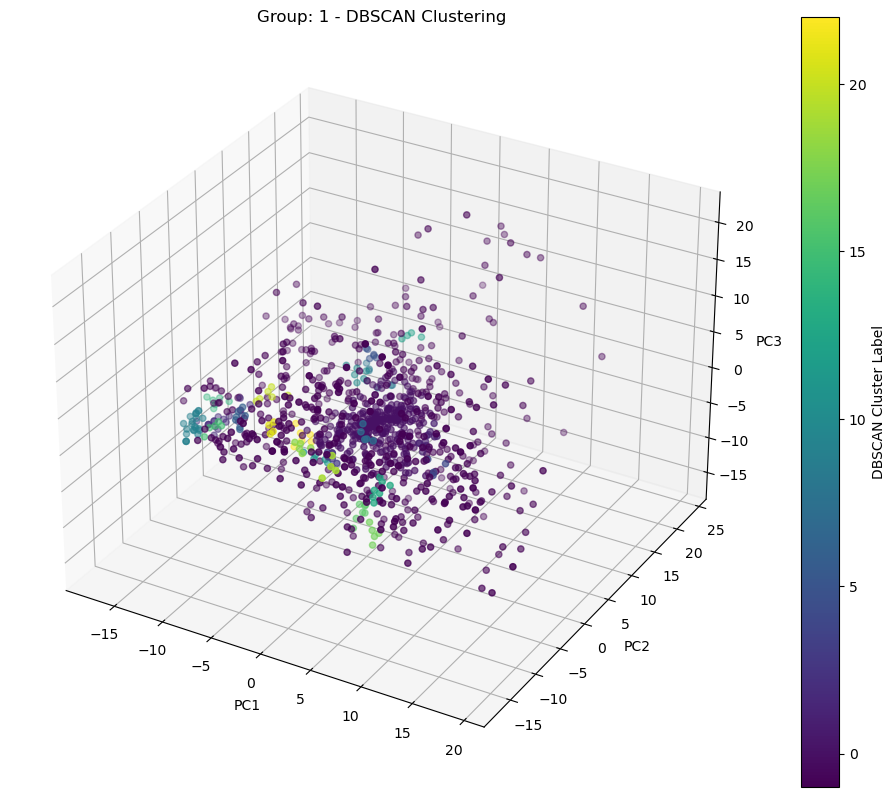

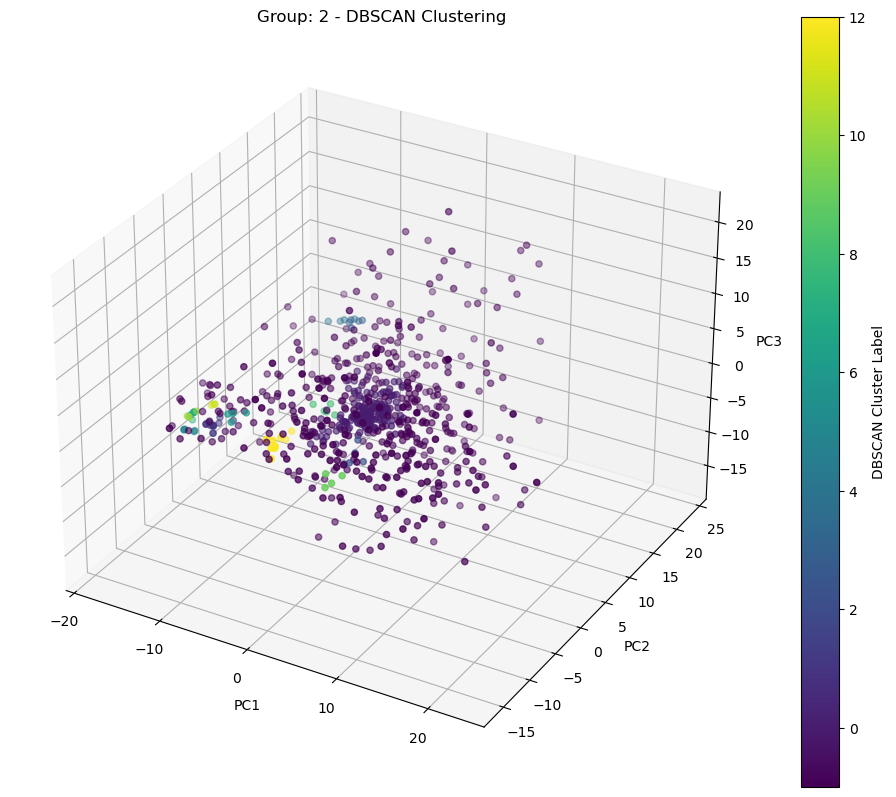

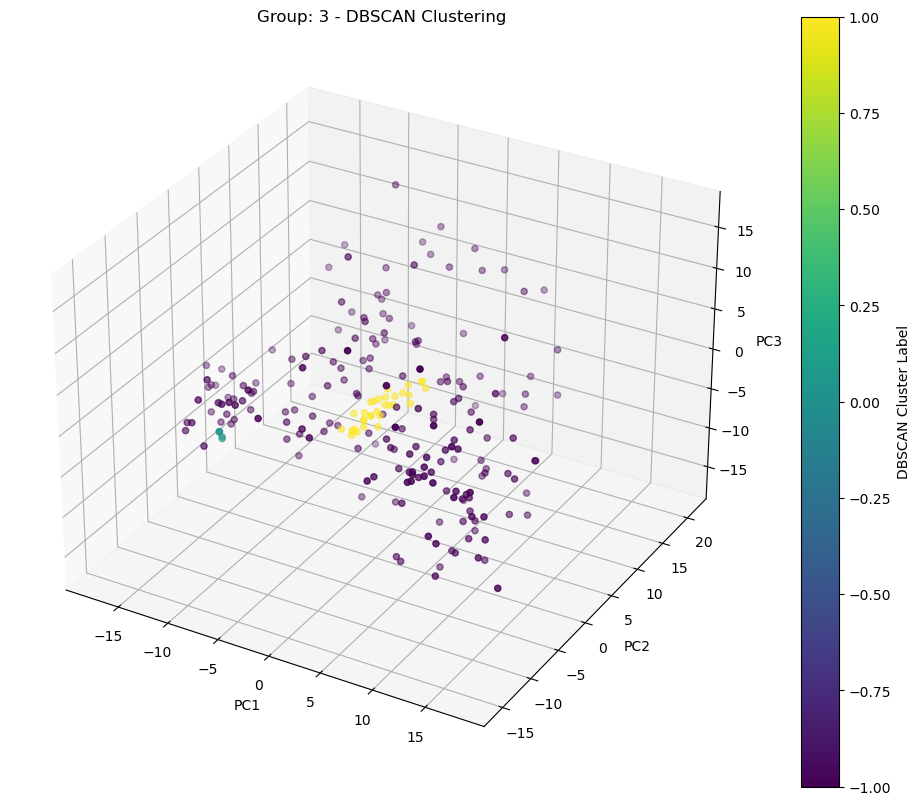

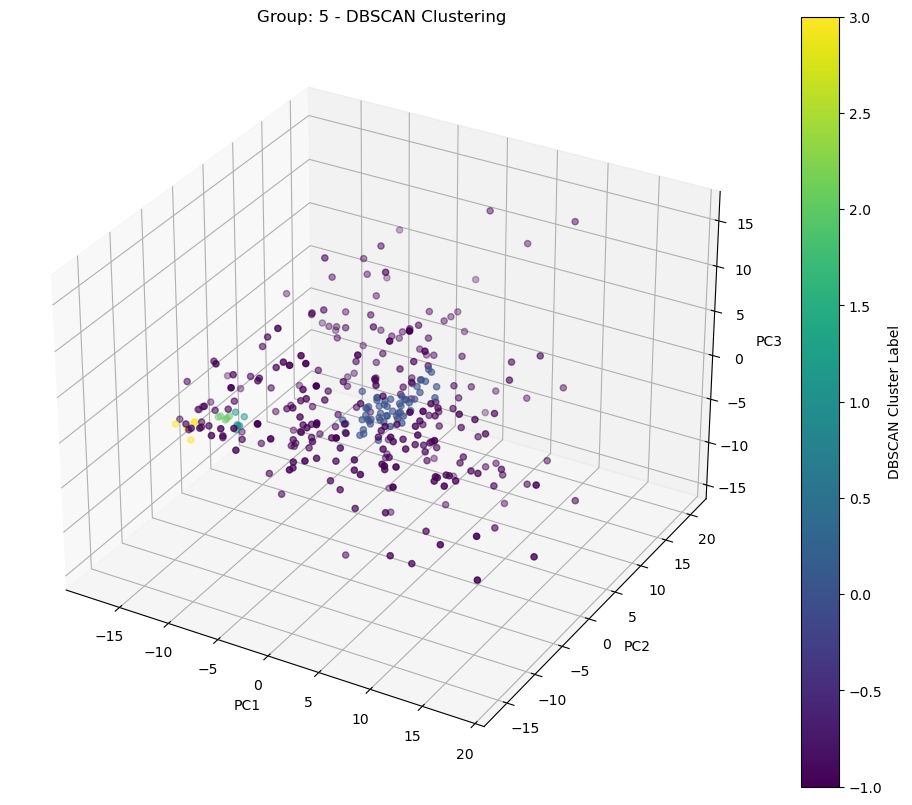

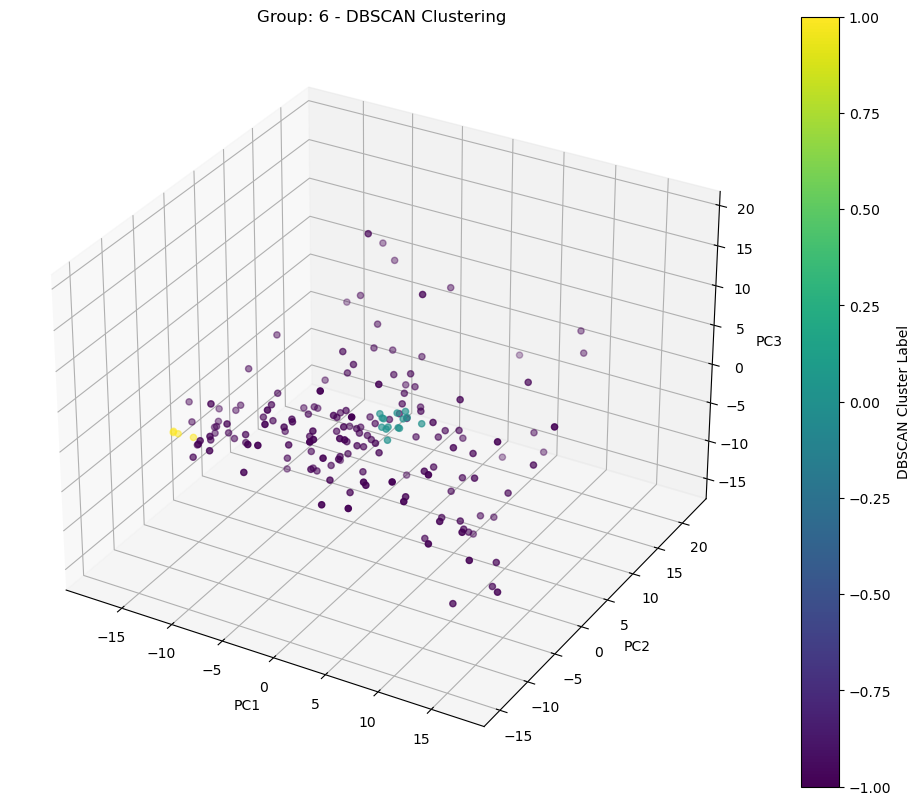

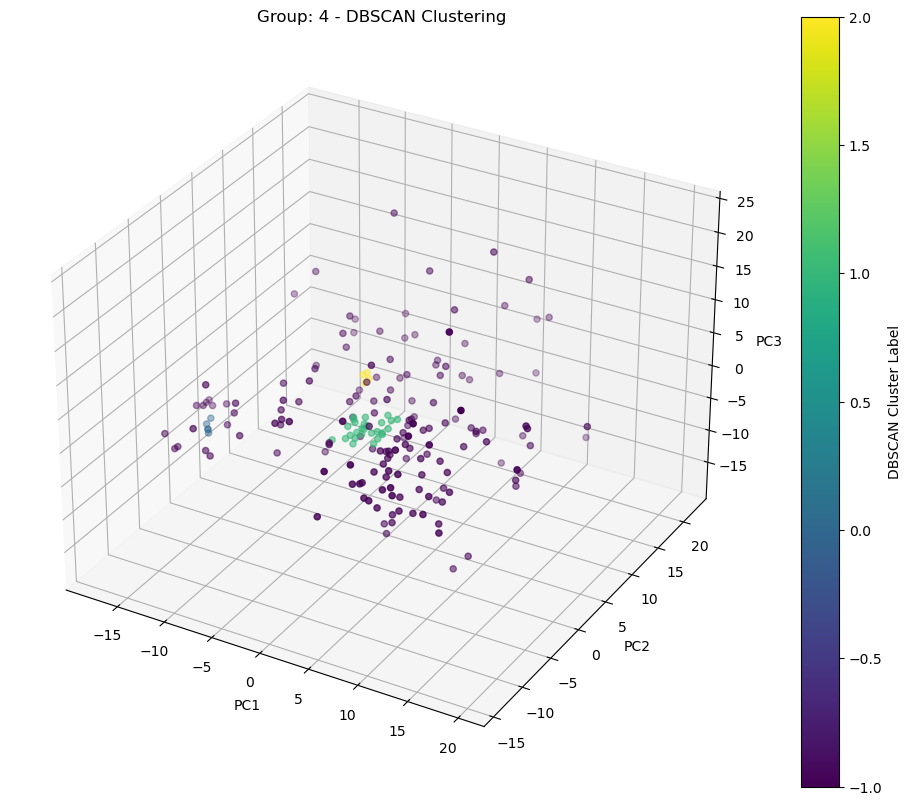

In [184]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Apply DBSCAN and plot for each group
def apply_dbscan_and_plot(df, eps=1.5, min_samples=4):
    # Get unique groups
    unique_groups = df['group'].unique()

    # Iterate over each group
    for group in unique_groups:
        # Filter the data for the current group
        group_data = df[df['group'] == group]

        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(group_data[['PC1', 'PC2', 'PC3']])

        # Add DBSCAN labels to the DataFrame
        group_data['dbscan_label'] = dbscan_labels

        # Plot 3D scatter plot
        fig = plt.figure(figsize=(12,10))
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(group_data['PC1'], group_data['PC2'], group_data['PC3'],
                             c=group_data['dbscan_label'], cmap='viridis', label=group)

        ax.set_title(f"Group: {group} - DBSCAN Clustering")
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')

        # Add colorbar for the DBSCAN cluster labels
        cbar = plt.colorbar(scatter)
        cbar.set_label('DBSCAN Cluster Label')

        # Show the plot
        plt.show()

# Assuming df_pca is already defined as in the previous step
apply_dbscan_and_plot(df_pca)


In [284]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform

# Step 1: Identify the largest cluster and calculate mean and std for each group
def calculate_stats_for_largest_cluster(df):
    group_stats = {}
    
    for group in df['group'].unique():
        group_data = df[df['group'] == group]
        dbscan = DBSCAN(eps=1, min_samples=4)
        dbscan_labels = dbscan.fit_predict(group_data[['PC1', 'PC2', 'PC3']])

        # Add DBSCAN labels to the DataFrame
        group_data['dbscan_label'] = dbscan_labels
        # Get the largest cluster
        largest_cluster_label = group_data['dbscan_label'].value_counts().idxmax()
        largest_cluster = group_data[group_data['dbscan_label'] == largest_cluster_label]
        
        # Calculate mean and std of features in the largest cluster
        group_stats[group] = {
            'mean': largest_cluster[['PC1', 'PC2', 'PC3']].mean().values,
            'std': largest_cluster[['PC1', 'PC2', 'PC3']].std().values
        }

    return group_stats

# def calculate_stats_for_largest_cluster(df):
#     group_stats = {}
    
#     for group in df['group'].unique():
#         group_data = df[df['group'] == group]
        
#         # Repeat the outlier removal process 3 times
#         for _ in range(3):
#             # Calculate mean and std of features
#             mean_values = group_data[['PC1', 'PC2', 'PC3']].mean()
#             std_values = group_data[['PC1', 'PC2', 'PC3']].std()
            
#             # Remove outliers that are more than 3 std from the mean
#             mask = (
#                 (abs(group_data['PC1'] - mean_values['PC1']) <= 3 * std_values['PC1']) &
#                 (abs(group_data['PC2'] - mean_values['PC2']) <= 3 * std_values['PC2']) &
#                 (abs(group_data['PC3'] - mean_values['PC3']) <= 3 * std_values['PC3'])
#             )
#             group_data = group_data[mask]
        
#         # Calculate final mean and std after outlier removal
#         final_mean = group_data[['PC1', 'PC2', 'PC3']].mean().values
#         final_std = group_data[['PC1', 'PC2', 'PC3']].std().values
        
#         group_stats[group] = {
#             'mean': final_mean,
#             'std': final_std
#         }

#     return group_stats

group_stats = calculate_stats_for_largest_cluster(df_pca)
pprint(group_stats)


{1: {'mean': array([-0.9116865 ,  0.19879878,  0.41642937], dtype=float32),
     'std': array([7.9456415, 7.034328 , 5.3396664], dtype=float32)},
 2: {'mean': array([1.8943936, 0.4269769, 0.6130353], dtype=float32),
     'std': array([8.287201, 7.444781, 5.379773], dtype=float32)},
 3: {'mean': array([ 0.39398542,  0.16685434, -0.8896485 ], dtype=float32),
     'std': array([7.8603454, 8.849478 , 5.562566 ], dtype=float32)},
 4: {'mean': array([1.7112116, 1.0323195, 0.1561604], dtype=float32),
     'std': array([7.825396 , 7.8775883, 5.2897596], dtype=float32)},
 5: {'mean': array([-1.2122654 , -0.9223256 , -0.20680746], dtype=float32),
     'std': array([7.820396 , 6.5790577, 4.998847 ], dtype=float32)},
 6: {'mean': array([-1.2146593, -0.6300909, -0.5444102], dtype=float32),
     'std': array([8.3423815, 7.1738815, 5.258619 ], dtype=float32)}}


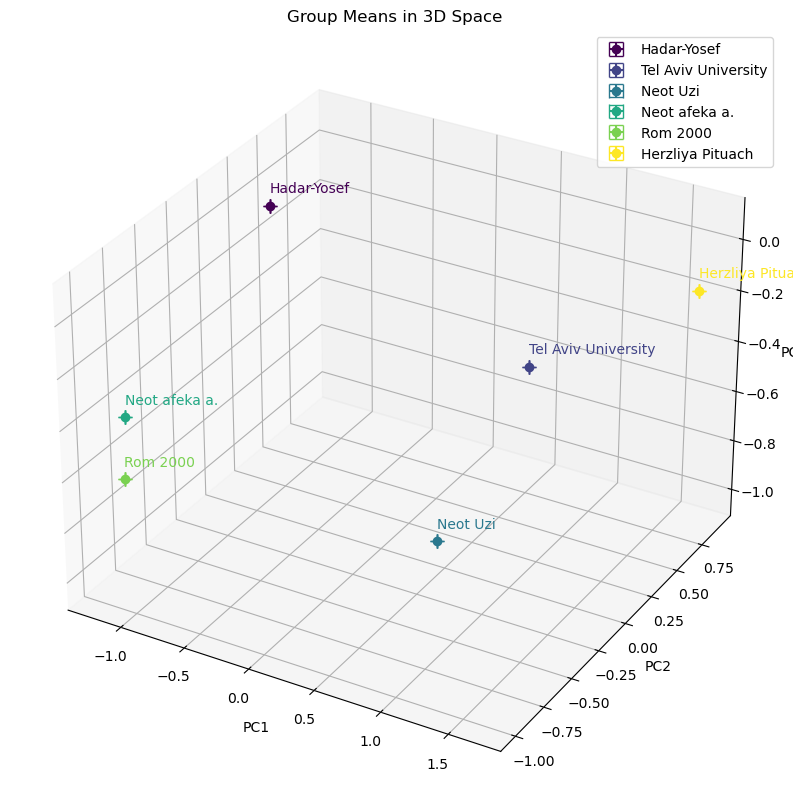

In [250]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

file_path = "/bigdata/users-home/dor/transpotation research/agg_data/grouped_neighbors.pickle"

# Read the pickle file
with open(file_path, 'rb') as handle:
    neighbors_dict = pickle.load(handle)
# Extract means and stds from group_stats
means = np.array([stats['mean'] for stats in group_stats.values()])
stds = np.array([stats['std'] for stats in group_stats.values()])
group_labels = list(group_stats.keys())

# Define a color map (you can adjust the colormap as needed)
colors = plt.cm.viridis(np.linspace(0, 1, len(group_labels)))

# Create a larger 3D plot (adjusting figsize)
fig = plt.figure(figsize=(12, 10))  # Increase the size (width, height)
ax = fig.add_subplot(111, projection='3d')

# Plot means with error bars, using different colors for each group
for i, label in enumerate(group_labels):
    ax.errorbar(means[i, 0], means[i, 1], means[i, 2], 
#                   xerr=stds[i, 0], yerr=stds[i, 1], zerr=stds[i, 2], 
                 xerr=0, yerr=0, zerr=0, 
                fmt='o', color=colors[i], label=neighbors_dict[label], capsize=5)

# Annotate each point with its group label
for i, label in enumerate(group_labels):
    ax.text(means[i, 0], means[i, 1], means[i, 2]+0.05, neighbors_dict[label], size=10, zorder=1, color=colors[i])

# Set labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Group Means in 3D Space')

# Show legend
ax.legend()

# Show the plot
plt.show()


K-Means Clustering (k = 2):
Group: Hadar-Yosef, Cluster: 1
Group: Tel Aviv University, Cluster: 0
Group: Neot Uzi, Cluster: 0
Group: Neot afeka a., Cluster: 1
Group: Rom 2000, Cluster: 1
Group: Herzliya Pituach, Cluster: 0

GMM Clustering (k = 2):
Group: Hadar-Yosef, Cluster: 1
Group: Tel Aviv University, Cluster: 0
Group: Neot Uzi, Cluster: 0
Group: Neot afeka a., Cluster: 1
Group: Rom 2000, Cluster: 1
Group: Herzliya Pituach, Cluster: 0

DBSCAN Clustering:
Group: Hadar-Yosef, Cluster: 0
Group: Tel Aviv University, Cluster: 0
Group: Neot Uzi, Cluster: 0
Group: Neot afeka a., Cluster: 0
Group: Rom 2000, Cluster: 0
Group: Herzliya Pituach, Cluster: 0


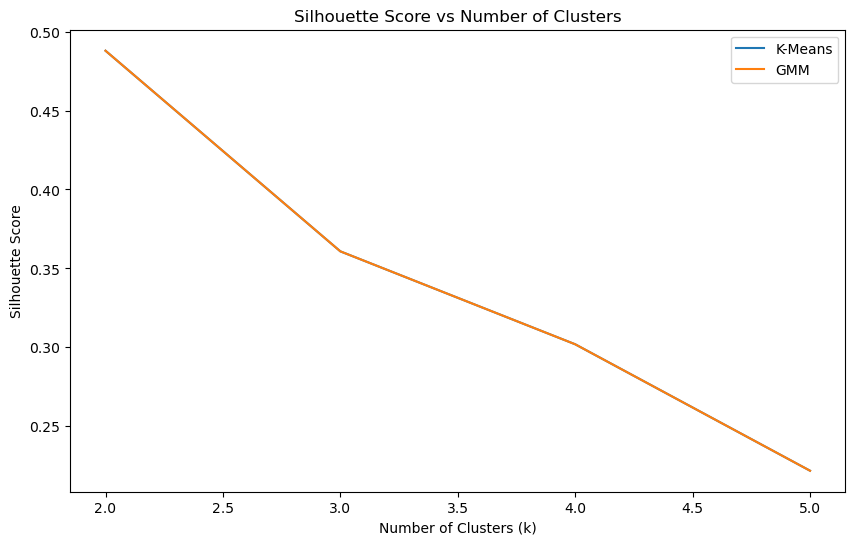

In [259]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Extract the means from the group_stats for clustering
X_means = np.array([stats['mean'] for stats in group_stats.values()])
group_labels = list(group_stats.keys())

# Function to evaluate silhouette scores for K-Means and GMM
def evaluate_clusterings(X, max_k=5):
    silhouette_scores_kmeans = []
    silhouette_scores_gmm = []
    
    for k in range(2, max_k + 1):
        # K-Means
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans_labels = kmeans.fit_predict(X)
        kmeans_silhouette = silhouette_score(X, kmeans_labels)
        silhouette_scores_kmeans.append(kmeans_silhouette)

        # GMM
        gmm = GaussianMixture(n_components=k, random_state=42)
        gmm_labels = gmm.fit_predict(X)
        gmm_silhouette = silhouette_score(X, gmm_labels)
        silhouette_scores_gmm.append(gmm_silhouette)

    return silhouette_scores_kmeans, silhouette_scores_gmm

# Evaluate silhouette scores
silhouette_scores_kmeans, silhouette_scores_gmm = evaluate_clusterings(X_means)

# Determine the best k for K-Means and GMM based on silhouette scores
best_k_kmeans = np.argmax(silhouette_scores_kmeans) + 2  # Add 2 because k starts from 2
best_k_gmm = np.argmax(silhouette_scores_gmm) + 2

# Apply K-Means and GMM with the best k
kmeans = KMeans(n_clusters=best_k_kmeans, random_state=42)
kmeans_labels = kmeans.fit_predict(X_means)

gmm = GaussianMixture(n_components=best_k_gmm, random_state=42)
gmm_labels = gmm.fit_predict(X_means)

# Apply DBSCAN
dbscan = DBSCAN(eps=2, min_samples=1)
dbscan_labels = dbscan.fit_predict(X_means)

# Print the clustering results
print("K-Means Clustering (k = {}):".format(best_k_kmeans))
for i, group in enumerate(group_labels):
    print(f"Group: {neighbors_dict[group]}, Cluster: {kmeans_labels[i]}")

print("\nGMM Clustering (k = {}):".format(best_k_gmm))
for i, group in enumerate(group_labels):
    print(f"Group: {neighbors_dict[group]}, Cluster: {gmm_labels[i]}")

print("\nDBSCAN Clustering:")
for i, group in enumerate(group_labels):
    print(f"Group: {neighbors_dict[group]}, Cluster: {dbscan_labels[i]}")

# Plotting the silhouette scores for K-Means and GMM
import matplotlib.pyplot as plt

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, len(silhouette_scores_kmeans) + 2), silhouette_scores_kmeans, label='K-Means')
plt.plot(range(2, len(silhouette_scores_gmm) + 2), silhouette_scores_gmm, label='GMM')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.legend()
plt.show()


In [139]:
from sklearn.preprocessing import StandardScaler
eps_values = [0.1, 0.5, 1.0]
min_samples_values = [5, 10, 20]
label_dict = {1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 1}
True_labels = [label_dict[i] for i in t_labels]

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_transformed_all)


In [195]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from scipy.optimize import linear_sum_assignment
from tabulate import tabulate

def map_cluster_labels(true_labels, cluster_labels):
    # Create a cost matrix based on matching true and predicted labels
    label_set_true = np.unique(true_labels)
    label_set_pred = np.unique(cluster_labels)
    cost_matrix = np.zeros((len(label_set_true), len(label_set_pred)))
    
    for i, true_label in enumerate(label_set_true):
        for j, cluster_label in enumerate(label_set_pred):
            match_count = np.sum((true_labels == true_label) & (cluster_labels == cluster_label))
            cost_matrix[i, j] = -match_count  # Negative for cost matrix
    
    # Solve the assignment problem
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    label_mapping = {label_set_pred[j]: label_set_true[i] for i, j in zip(row_ind, col_ind)}
    
    # Map cluster labels to true labels
    mapped_labels = np.array([label_mapping[label] for label in cluster_labels])
    
    return mapped_labels

def clustering_accuracy(true_labels, predicted_labels):
    mapped_labels = map_cluster_labels(true_labels, predicted_labels)
    return accuracy_score(true_labels, mapped_labels)

def evaluate_clustering_methods_v2(data, true_labels):
    methods = {
        'KMeans': KMeans(n_clusters=len(np.unique(true_labels)), random_state=42),
        'KMedoids': KMedoids(n_clusters=len(np.unique(true_labels)), random_state=42),
        'Agglomerative': AgglomerativeClustering(n_clusters=len(np.unique(true_labels))),
        'GMM': GaussianMixture(n_components=len(np.unique(true_labels)), random_state=42),
        'Spectral': SpectralClustering(n_clusters=len(np.unique(true_labels)), affinity='nearest_neighbors', random_state=42)
    }
    
    results = {}
    
    for method_name, method in methods.items():
        if method_name == 'DBSCAN':
            predicted_labels = method.fit_predict(data)
            valid_indices = predicted_labels != -1
            acc = clustering_accuracy(true_labels[valid_indices], predicted_labels[valid_indices])
        elif method_name == 'GMM':
            predicted_labels = method.fit(data).predict(data)
            acc = clustering_accuracy(true_labels, predicted_labels)
        else:
            predicted_labels = method.fit_predict(data)
            acc = clustering_accuracy(true_labels, predicted_labels)
        
        ari = adjusted_rand_score(true_labels, predicted_labels)
        nmi = normalized_mutual_info_score(true_labels, predicted_labels)
        
        if method_name != 'DBSCAN':
            silhouette = silhouette_score(data, predicted_labels)
        else:
            silhouette = silhouette_score(data[valid_indices], predicted_labels[valid_indices])
        
        results[method_name] = {
            'Accuracy': acc,
            'ARI': ari,
            'NMI': nmi,
            'Silhouette': silhouette
        }
        
    return results

def print_results_table(results):
    # Create a DataFrame from the results dictionary
    df_results = pd.DataFrame(results).T

    # Print the DataFrame as a formatted table
    print(tabulate(df_results, headers='keys', tablefmt='pretty', floatfmt=".2f"))

# Example usage

eps_values = [0.5, 1, 1.5, 2,0.1]  # Example eps values
min_samples_values = [3, 4, 5,2,6,7]
eps_values = [0.5]  # Example eps values
min_samples_values = [3, 4, 5]
for eps in eps_values:
        for min_samples in min_samples_values:
            lst = []
            print('eps:',eps,'min_samp:',min_samples)
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            for group in df_pca['group'].unique():
                group_data = df_pca[df_pca['group'] == group]
                dbscan_labels = dbscan.fit_predict(group_data[['PC1', 'PC2', 'PC3']])

                # Add DBSCAN labels to the DataFrame
                group_data['dbscan_label'] = dbscan_labels
                # Get the largest cluster
                largest_cluster_label = group_data['dbscan_label'].value_counts().idxmax()
                largest_cluster = group_data[group_data['dbscan_label'] == largest_cluster_label]
                largest_cluster['group'] = label_dict[group]
                largest_cluster[f'patt'] = group
                lst.append(largest_cluster)

            df_no_group = pd.concat(lst, ignore_index=True)
            # Create dummy variables from the 'patt' column
            patt_dummies = pd.get_dummies(df_no_group['patt'], prefix='patt')

            # Concatenate the dummy variables with df_no_group
            df_no_group = pd.concat([df_no_group, patt_dummies], axis=1)

            # Remove the original 'patt' column
            df_no_group = df_no_group.drop(columns=['patt'])
            df_transformed_except = df_no_group.drop(columns=['group'])

            results = evaluate_clustering_methods_v2(df_transformed_except, np.array(df_no_group['group']))
            print_results_table(results)
# for method, scores in results.items():
#     print(f"{method}:")
#     print(f"  Accuracy: {scores['Accuracy']:.2f}")
#     print(f"  ARI: {scores['ARI']:.2f}")
#     print(f"  NMI: {scores['NMI']:.2f}")


eps: 0.5 min_samp: 3
+---------------+--------------------+-----------------------+-----------------------+----------------------+
|               |      Accuracy      |          ARI          |          NMI          |      Silhouette      |
+---------------+--------------------+-----------------------+-----------------------+----------------------+
|    KMeans     | 0.5940959409594095 | 0.022552284606091006  | 0.005546616215779297  | 0.24445006590545806  |
|   KMedoids    | 0.5366953669536695 | 0.004092404232322997  |  0.00935152645269654  | 0.23443663736864712  |
| Agglomerative | 0.5887658876588766 | 0.014399666582825864  | 0.002315082970913896  |  0.2347452717604997  |
|      GMM      | 0.5026650266502665 | -0.05153704897194433  |  0.14140980477988493  | 0.030313020685097242 |
|   Spectral    | 0.6150061500615006 | -0.014215469374364752 | 0.0020545672526309667 | 0.26605143473514997  |
+---------------+--------------------+-----------------------+-----------------------+-------------

In [296]:
import pandas as pd
import numpy as np
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Initialize matrices to store clustering results
kmeans_matrix = np.zeros((6, 6))
gmm_matrix = np.zeros((6, 6))
dbscan_matrix = np.zeros((6, 6))
spectral_matrix = np.zeros((6, 6))

def compute_cluster(rand=100):
    """
    Computes clusters using MiniRocket transformation, PCA, and various clustering algorithms.
    Returns the labels for K-Means, GMM, DBSCAN, and Spectral Clustering.
    """
    def convert_dfs_to_arrays(df_list):
        """Convert list of DataFrames to numpy arrays."""
        arrays = []
        labels = []
        for df in df_list:
            arrays.append(df[['speed', 'acceleration_est_1', 'angular_acc']].values.T)  # Shape: (num_features, num_timesteps)
            labels.append(df.iloc[0]['group'])
        return np.stack(arrays, axis=0), labels

    t_labels = []  # True labels
    X_transformed_list = []  # List to store transformed arrays

    # Transform each DataFrame in dict_length using MiniRocket
    for key in dict_length:
        arrays, true_labels = convert_dfs_to_arrays(dict_length[key])
        t_labels += true_labels
        
        # Create and fit the MiniRocket transformer
        rocket = MiniRocketMultivariate(num_kernels=10000, random_state=int(rand))
        rocket.fit(arrays)

        # Transform the data and store it
        X_transformed = rocket.transform(arrays)
        X_transformed_list.append(X_transformed)

    # Concatenate all transformed arrays along the first axis
    X_transformed_all = np.concatenate(X_transformed_list, axis=0)

    # Apply PCA to reduce dimensions to 3 components
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_transformed_all)
    df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
    df_pca['group'] = t_labels

    # Calculate statistics for the largest cluster
    group_stats = calculate_stats_for_largest_cluster(df_pca)

    # Extract means for clustering
    X_means = np.array([stats['mean'] for stats in group_stats.values()])
    group_labels = list(group_stats.keys())

    def evaluate_clusterings(X, max_k=5):
        """Evaluate silhouette scores for K-Means and GMM."""
        silhouette_scores_kmeans = []
        silhouette_scores_gmm = []
        silhouette_scores_spectral = []

        for k in range(2, max_k + 1):
            # K-Means
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans_labels = kmeans.fit_predict(X)
            silhouette_scores_kmeans.append(silhouette_score(X, kmeans_labels))

            # Gaussian Mixture Model
            gmm = GaussianMixture(n_components=k, random_state=42)
            gmm_labels = gmm.fit_predict(X)
            silhouette_scores_gmm.append(silhouette_score(X, gmm_labels))

            # Spectral Clustering
            spectral = SpectralClustering(n_clusters=k, random_state=42)
            spectral_labels = spectral.fit_predict(X)
            silhouette_scores_spectral.append(silhouette_score(X, spectral_labels))

        return silhouette_scores_kmeans, silhouette_scores_gmm, silhouette_scores_spectral

    # Evaluate silhouette scores for each clustering method
    silhouette_scores_kmeans, silhouette_scores_gmm, silhouette_scores_spectral = evaluate_clusterings(X_means)

    # Determine the best k for each clustering method based on silhouette scores
    best_k_kmeans = np.argmax(silhouette_scores_kmeans) + 2
    best_k_gmm = np.argmax(silhouette_scores_gmm) + 2
    best_k_spectral = np.argmax(silhouette_scores_spectral) + 2

    # Apply K-Means, GMM, DBSCAN, and Spectral Clustering with the best k
    kmeans_labels = KMeans(n_clusters=best_k_kmeans, random_state=42).fit_predict(X_means)
    gmm_labels = GaussianMixture(n_components=best_k_gmm, random_state=42).fit_predict(X_means)
    dbscan_labels = DBSCAN(eps=1, min_samples=1).fit_predict(X_means)
    spectral_labels = SpectralClustering(n_clusters=best_k_spectral, random_state=42).fit_predict(X_means)

    return kmeans_labels, gmm_labels, dbscan_labels, spectral_labels

# Main execution loop
num_runs = 500
random_states = np.random.randint(0, 1000, size=num_runs)

for rand in random_states:
    kmeans_labels, gmm_labels, dbscan_labels, spectral_labels = compute_cluster(rand)

    # Dictionaries to count occurrences of clustering
    k_cluster_dict = {}
    g_cluster_dict = {}
    d_cluster_dict = {}
    s_cluster_dict = {}

    # Count occurrences of clustering for each method
    for i, group in enumerate(group_labels):
        k_cluster_dict[group] = kmeans_labels[i]
        g_cluster_dict[group] = gmm_labels[i]
        d_cluster_dict[group] = dbscan_labels[i]
        s_cluster_dict[group] = spectral_labels[i]

    # Update matrices based on clustering results
    for group in k_cluster_dict:
        for j in k_cluster_dict:
            if k_cluster_dict[group] == k_cluster_dict[j]:
                kmeans_matrix[int(group - 1), int(j - 1)] += 1
                
    for group in g_cluster_dict:
        for j in g_cluster_dict:
            if g_cluster_dict[group] == g_cluster_dict[j]:
                gmm_matrix[int(group - 1), int(j - 1)] += 1
                
    for group in d_cluster_dict:
        for j in d_cluster_dict:
            if d_cluster_dict[group] == d_cluster_dict[j]:
                dbscan_matrix[int(group - 1), int(j - 1)] += 1
                
    for group in s_cluster_dict:
        for j in s_cluster_dict:
            if s_cluster_dict[group] == s_cluster_dict[j]:
                spectral_matrix[int(group - 1), int(j - 1)] += 1



In [309]:
def highlight_cells(val):
    color = 'background-color: lightgreen' if val > 0.8 else ''
    return color


In [314]:
rounded_kmeans_matrix = np.round(kmeans_matrix / num_runs, decimals=2)
# Create a DataFrame from the rounded matrix
df_kmeans = pd.DataFrame(rounded_kmeans_matrix, 
                         index=[neighbors_dict[i+1] for i in range(len(neighbors_dict))], 
                         columns=[neighbors_dict[i+1] for i in range(len(neighbors_dict))])
df_kmeans = df_kmeans.style.applymap(highlight_cells)
df_kmeans

,Hadar-Yosef,Tel Aviv University,Neot Uzi,Herzliya Pituach,Neot afeka a.,Rom 2000
Hadar-Yosef,1.000000,0.020000,0.260000,0.020000,0.940000,0.940000
Tel Aviv University,0.020000,1.000000,0.750000,1.000000,0.000000,0.000000
Neot Uzi,0.260000,0.750000,1.000000,0.750000,0.210000,0.210000
Herzliya Pituach,0.020000,1.000000,0.750000,1.000000,0.000000,0.000000
Neot afeka a.,0.940000,0.000000,0.210000,0.000000,1.000000,1.000000
Rom 2000,0.940000,0.000000,0.210000,0.000000,1.000000,1.000000


In [313]:
rounded_gmm_matrix=np.round(gmm_matrix / num_runs, decimals=2)
df_gmm = pd.DataFrame(rounded_gmm_matrix, 
                         index=[neighbors_dict[i+1] for i in range(len(neighbors_dict))], 
                         columns=[neighbors_dict[i+1] for i in range(len(neighbors_dict))])
df_gmm = df_gmm.style.applymap(highlight_cells)
df_gmm

,Hadar-Yosef,Tel Aviv University,Neot Uzi,Herzliya Pituach,Neot afeka a.,Rom 2000
Hadar-Yosef,1.000000,0.020000,0.260000,0.020000,0.940000,0.940000
Tel Aviv University,0.020000,1.000000,0.750000,1.000000,0.000000,0.000000
Neot Uzi,0.260000,0.750000,1.000000,0.750000,0.210000,0.210000
Herzliya Pituach,0.020000,1.000000,0.750000,1.000000,0.000000,0.000000
Neot afeka a.,0.940000,0.000000,0.210000,0.000000,1.000000,1.000000
Rom 2000,0.940000,0.000000,0.210000,0.000000,1.000000,1.000000


In [312]:
rounded_db_matrix=np.round(dbscan_matrix / num_runs, decimals=2)
df_db = pd.DataFrame(rounded_db_matrix, 
                         index=[neighbors_dict[i+1] for i in range(len(neighbors_dict))], 
                         columns=[neighbors_dict[i+1] for i in range(len(neighbors_dict))])
df_db = df_db.style.applymap(highlight_cells)
df_db

,Hadar-Yosef,Tel Aviv University,Neot Uzi,Herzliya Pituach,Neot afeka a.,Rom 2000
Hadar-Yosef,1.000000,0.000000,0.060000,0.000000,0.320000,0.300000
Tel Aviv University,0.000000,1.000000,0.000000,0.670000,0.000000,0.000000
Neot Uzi,0.060000,0.000000,1.000000,0.000000,0.020000,0.020000
Herzliya Pituach,0.000000,0.670000,0.000000,1.000000,0.000000,0.000000
Neot afeka a.,0.320000,0.000000,0.020000,0.000000,1.000000,0.920000
Rom 2000,0.300000,0.000000,0.020000,0.000000,0.920000,1.000000


In [310]:
import pandas as pd
import numpy as np



rounded_spectral_matrix=np.round(spectral_matrix / num_runs, decimals=2)
df_spectral = pd.DataFrame(rounded_spectral_matrix, 
                         index=[neighbors_dict[i+1] for i in range(len(neighbors_dict))], 
                         columns=[neighbors_dict[i+1] for i in range(len(neighbors_dict))])
df_spectral = df_spectral.style.applymap(highlight_cells)
df_spectral


,Hadar-Yosef,Tel Aviv University,Neot Uzi,Herzliya Pituach,Neot afeka a.,Rom 2000
Hadar-Yosef,1.000000,0.000000,0.580000,0.000000,0.970000,0.970000
Tel Aviv University,0.000000,1.000000,0.420000,1.000000,0.000000,0.000000
Neot Uzi,0.580000,0.420000,1.000000,0.420000,0.560000,0.560000
Herzliya Pituach,0.000000,1.000000,0.420000,1.000000,0.000000,0.000000
Neot afeka a.,0.970000,0.000000,0.560000,0.000000,1.000000,1.000000
Rom 2000,0.970000,0.000000,0.560000,0.000000,1.000000,1.000000


In [285]:
import pandas as pd
import numpy as np
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

kmeans_matrix = np.zeros((6, 6))
gmm_matrix = np.zeros((6, 6))
dbscan_matrix = np.zeros((6, 6))

def compute_cluster(rand = 100):
    # Define the convert_dfs_to_arrays function
    def convert_dfs_to_arrays(df_list):
        arrays = []
        labels = []
        for df in df_list:
            arrays.append(df[['speed', 'acceleration_est_1', 'angular_acc']].values.T)  # Transpose to get shape (num_features, num_timesteps)
            labels.append(df.iloc[0]['group'])
        return np.stack(arrays, axis=0), labels

    t_labels = []
    X_transformed_list = []  # List to store all transformed arrays

    for key in dict_length:
        arrays, true_labels = convert_dfs_to_arrays(dict_length[key])
        t_labels += true_labels
        # Create the MiniRocketMultivariate transformer
        rocket = MiniRocketMultivariate(num_kernels=10000 , random_state=int(rand))  # Adjust num_kernels as needed

        # Fit the transformer on your data
        rocket.fit(arrays)

        # Transform the data
        X_transformed = rocket.transform(arrays)

        # Append the transformed data to the list
        X_transformed_list.append(X_transformed)

    # Concatenate all transformed arrays along the first axis
    X_transformed_all = np.concatenate(X_transformed_list, axis=0)

    from sklearn.decomposition import PCA

    # Apply PCA to the transformed data, keeping the first 3 components
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_transformed_all)

    # Create a DataFrame from the PCA result
    df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])

    # Add the 'group' labels to the DataFrame
    df_pca['group'] = t_labels


    group_stats = calculate_stats_for_largest_cluster(df_pca)



    # Extract the means from the group_stats for clustering
    X_means = np.array([stats['mean'] for stats in group_stats.values()])
    group_labels = list(group_stats.keys())

    # Function to evaluate silhouette scores for K-Means and GMM
    def evaluate_clusterings(X, max_k=5):
        silhouette_scores_kmeans = []
        silhouette_scores_gmm = []

        for k in range(2, max_k + 1):
            # K-Means
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans_labels = kmeans.fit_predict(X)
            kmeans_silhouette = silhouette_score(X, kmeans_labels)
            silhouette_scores_kmeans.append(kmeans_silhouette)

            # GMM
            gmm = GaussianMixture(n_components=k, random_state=42)
            gmm_labels = gmm.fit_predict(X)
            gmm_silhouette = silhouette_score(X, gmm_labels)
            silhouette_scores_gmm.append(gmm_silhouette)

        return silhouette_scores_kmeans, silhouette_scores_gmm

    # Evaluate silhouette scores
    silhouette_scores_kmeans, silhouette_scores_gmm = evaluate_clusterings(X_means)

    # Determine the best k for K-Means and GMM based on silhouette scores
    best_k_kmeans = np.argmax(silhouette_scores_kmeans) + 2  # Add 2 because k starts from 2
    best_k_gmm = np.argmax(silhouette_scores_gmm) + 2

    # Apply K-Means and GMM with the best k
    kmeans = KMeans(n_clusters=best_k_kmeans, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_means)

    gmm = GaussianMixture(n_components=best_k_gmm, random_state=42)
    gmm_labels = gmm.fit_predict(X_means)

    # Apply DBSCAN
    dbscan = DBSCAN(eps=1, min_samples=1)
    dbscan_labels = dbscan.fit_predict(X_means)
    #     # Print the clustering results
#     print("K-Means Clustering (k = {}):".format(best_k_kmeans))
#     for i, group in enumerate(group_labels):
#         print(f"Group: {neighbors_dict[group]}, Cluster: {kmeans_labels[i]}")

#     print("\nGMM Clustering (k = {}):".format(best_k_gmm))
#     for i, group in enumerate(group_labels):
#         print(f"Group: {neighbors_dict[group]}, Cluster: {gmm_labels[i]}")

#     print("\nDBSCAN Clustering:")
#     for i, group in enumerate(group_labels):
#         print(f"Group: {neighbors_dict[group]}, Cluster: {dbscan_labels[i]}")

    return kmeans_labels , gmm_labels , dbscan_labels

num_runs = 500
random_states = np.random.randint(0, 1000, size=num_runs)
for rand in random_states:
    kmeans_labels , gmm_labels , dbscan_labels = compute_cluster(rand)
    k_cluster_dict = {}
    g_cluster_dict = {}
    d_cluster_dict = {}
    # Count the occurrences of clustering together for K-Means
    for i, group in enumerate(group_labels):
        k_cluster_dict[group] = kmeans_labels[i]
        
    for i, group in enumerate(group_labels):
        g_cluster_dict[group] = gmm_labels[i]
        
    for i, group in enumerate(group_labels):
        d_cluster_dict[group] = dbscan_labels[i]
        
    for group in k_cluster_dict:
        for j in k_cluster_dict:
            if k_cluster_dict[group] == k_cluster_dict[j] :
                kmeans_matrix[int(group-1), int(j-1)] += 1
                
    for group in g_cluster_dict:
        for j in g_cluster_dict:
            if g_cluster_dict[group] == g_cluster_dict[j] :
                gmm_matrix[int(group-1), int(j-1)] += 1
                
    for group in d_cluster_dict:
        for j in d_cluster_dict:
            if d_cluster_dict[group] == d_cluster_dict[j] :
                dbscan_matrix[int(group-1), int(j-1)] += 1
                
#     # Count the occurrences of clustering together for GMM
#     for i in range(len(gmm_labels)):
#         for j in range(len(gmm_labels)):
#             if gmm_labels[i] == gmm_labels[j] :
#                 gmm_matrix[int(i), int(j)] += 1

#     # Count the occurrences of clustering together for DBSCAN
#     for i in range(len(dbscan_labels)):
#         for j in range(len(dbscan_labels)):
#             if dbscan_labels[i] == dbscan_labels[j] :
#                 dbscan_matrix[int(i), int(j)] += 1
        


In [290]:
rounded_kmeans_matrix = np.round(kmeans_matrix / num_runs, decimals=2)
# Create a DataFrame from the rounded matrix
df_kmeans = pd.DataFrame(rounded_kmeans_matrix, 
                         index=[neighbors_dict[i+1] for i in range(len(neighbors_dict))], 
                         columns=[neighbors_dict[i+1] for i in range(len(neighbors_dict))])
df_kmeans

,Hadar-Yosef,Tel Aviv University,Neot Uzi,Herzliya Pituach,Neot afeka a.,Rom 2000
Hadar-Yosef,1.00,0.02,0.27,0.02,0.93,0.93
Tel Aviv University,0.02,1.00,0.74,1.00,0.00,0.00
Neot Uzi,0.27,0.74,1.00,0.74,0.20,0.20
Herzliya Pituach,0.02,1.00,0.74,1.00,0.00,0.00
Neot afeka a.,0.93,0.00,0.20,0.00,1.00,1.00
Rom 2000,0.93,0.00,0.20,0.00,1.00,1.00


In [287]:
rounded_gmm_matrix=np.round(gmm_matrix / num_runs, decimals=2)
df_gmm = pd.DataFrame(rounded_gmm_matrix, 
                         index=[neighbors_dict[i+1] for i in range(len(neighbors_dict))], 
                         columns=[neighbors_dict[i+1] for i in range(len(neighbors_dict))])
df_gmm

,Hadar-Yosef,Tel Aviv University,Neot Uzi,Herzliya Pituach,Neot afeka a.,Rom 2000
Hadar-Yosef,1.00,0.02,0.27,0.02,0.93,0.93
Tel Aviv University,0.02,1.00,0.74,1.00,0.00,0.00
Neot Uzi,0.27,0.74,1.00,0.74,0.20,0.20
Herzliya Pituach,0.02,1.00,0.74,1.00,0.00,0.00
Neot afeka a.,0.93,0.00,0.20,0.00,1.00,1.00
Rom 2000,0.93,0.00,0.20,0.00,1.00,1.00


In [288]:
rounded_db_matrix=np.round(dbscan_matrix / num_runs, decimals=2)
df_db = pd.DataFrame(rounded_db_matrix, 
                         index=[neighbors_dict[i+1] for i in range(len(neighbors_dict))], 
                         columns=[neighbors_dict[i+1] for i in range(len(neighbors_dict))])
df_db

,Hadar-Yosef,Tel Aviv University,Neot Uzi,Herzliya Pituach,Neot afeka a.,Rom 2000
Hadar-Yosef,1.00,0.00,0.08,0.00,0.30,0.28
Tel Aviv University,0.00,1.00,0.00,0.66,0.00,0.00
Neot Uzi,0.08,0.00,1.00,0.00,0.01,0.01
Herzliya Pituach,0.00,0.66,0.00,1.00,0.00,0.00
Neot afeka a.,0.30,0.00,0.01,0.00,1.00,0.92
Rom 2000,0.28,0.00,0.01,0.00,0.92,1.00


In [197]:
import pandas as pd
import numpy as np
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import KFold
from collections import defaultdict

# Define the convert_dfs_to_arrays function
def convert_dfs_to_arrays(df_list):
    arrays = []
    labels = []
    for df in df_list:
        arrays.append(df[['speed', 'acceleration_est_1', 'angular_acc']].values.T)  # Transpose to get shape (num_features, num_timesteps)
        labels.append(df.iloc[0]['group'])
    return np.stack(arrays, axis=0), labels

# Function to calculate the co-clustering frequency matrix
def update_coclustering_matrix(matrix, labels):
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            if labels[i] == labels[j]:  # Check if they are in the same cluster
                matrix[i][j] += 1
                matrix[j][i] += 1
    return matrix

# Set up parameters
num_runs = 15
num_kernels = 10000  # Adjust this value if needed
k_folds = 5
random_states = np.random.randint(0, 1000, size=num_runs)  # Generate 15 random states

# Initialize an empty co-clustering matrix
num_samples = len(t_labels)
coclustering_matrix = np.zeros((num_samples, num_samples))

# Perform 15 different runs
for run_idx, random_state in enumerate(random_states):
    print(f"Run {run_idx + 1}/{num_runs} with random state {random_state}")
    
    t_labels = []
    X_transformed_list = []  # List to store all transformed arrays
    
    # For each group, transform the data using MiniRocketMultivariate
    for key in dict_length:
        arrays, true_labels = convert_dfs_to_arrays(dict_length[key])
        t_labels += true_labels
        # Create the MiniRocketMultivariate transformer with a different random state
        rocket = MiniRocketMultivariate(num_kernels=num_kernels, random_state=int(random_state))
        
        # Fit and transform the data
        rocket.fit(arrays)
        X_transformed = rocket.transform(arrays)
        X_transformed_list.append(X_transformed)
    
    # Concatenate all transformed arrays
    X_transformed_all = np.concatenate(X_transformed_list, axis=0)
    
    # Apply PCA to the transformed data
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_transformed_all)
    
    # Add 'group' labels to PCA DataFrame
    df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
    df_pca['group'] = t_labels
    
    # Perform k-fold cross-validation clustering
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)
    for train_idx, test_idx in kf.split(df_pca):
        X_train, X_test = df_pca.iloc[train_idx], df_pca.iloc[test_idx]
        
        # Apply KMeans clustering
        kmeans = KMeans(n_clusters=best_k_kmeans, random_state=random_state)
        kmeans_labels = kmeans.fit_predict(X_test[['PC1', 'PC2', 'PC3']])
        
        # Update the co-clustering matrix
        update_coclustering_matrix(coclustering_matrix, kmeans_labels)

# Normalize the co-clustering matrix
coclustering_matrix /= num_runs

# Create a DataFrame to show the proportion of times each pair of groups were clustered together
coclustering_df = pd.DataFrame(coclustering_matrix, columns=t_labels, index=t_labels)

# Print the co-clustering proportions
print(coclustering_df)


Run 1/15 with random state 704


IndexError: index 205 is out of bounds for axis 0 with size 205

In [199]:
import pandas as pd
import numpy as np
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import KFold
from collections import defaultdict

# Define the convert_dfs_to_arrays function
def convert_dfs_to_arrays(df_list):
    arrays = []
    labels = []
    for df in df_list:
        arrays.append(df[['speed', 'acceleration_est_1', 'angular_acc']].values.T)  # Transpose to get shape (num_features, num_timesteps)
        labels.append(df.iloc[0]['group'])
    return np.stack(arrays, axis=0), labels

# Function to calculate the co-clustering frequency matrix
def update_coclustering_matrix(matrix, labels, indices):
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            if labels[i] == labels[j]:  # Check if they are in the same cluster
                matrix[indices[i]][indices[j]] += 1
                matrix[indices[j]][indices[i]] += 1
    return matrix

# Set up parameters
num_runs = 15
num_kernels = 10000  # Adjust this value if needed
k_folds = 5
random_states = np.random.randint(0, 1000, size=num_runs)  # Generate 15 random states

# Initialize an empty co-clustering matrix
num_samples = len(t_labels)
coclustering_matrix = np.zeros((num_samples, num_samples))

# Perform 15 different runs
for run_idx, random_state in enumerate(random_states):
    print(f"Run {run_idx + 1}/{num_runs} with random state {random_state}")
    
    t_labels = []
    X_transformed_list = []  # List to store all transformed arrays
    
    # For each group, transform the data using MiniRocketMultivariate
    for key in dict_length:
        arrays, true_labels = convert_dfs_to_arrays(dict_length[key])
        t_labels += true_labels
        # Create the MiniRocketMultivariate transformer with a different random state
        rocket = MiniRocketMultivariate(num_kernels=num_kernels, random_state=int(random_state))
        
        # Fit and transform the data
        rocket.fit(arrays)
        X_transformed = rocket.transform(arrays)
        X_transformed_list.append(X_transformed)
    
    # Concatenate all transformed arrays
    X_transformed_all = np.concatenate(X_transformed_list, axis=0)
    
    # Apply PCA to the transformed data
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_transformed_all)
    
    # Add 'group' labels to PCA DataFrame
    df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
    df_pca['group'] = t_labels
    
    # Perform k-fold cross-validation clustering
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)
    for train_idx, test_idx in kf.split(df_pca):
        X_train, X_test = df_pca.iloc[train_idx], df_pca.iloc[test_idx]
        
        # Apply KMeans clustering
        kmeans = KMeans(n_clusters=best_k_kmeans, random_state=random_state)
        kmeans_labels = kmeans.fit_predict(X_test[['PC1', 'PC2', 'PC3']])
        
        # Update the co-clustering matrix using the indices of the test set
        update_coclustering_matrix(coclustering_matrix, kmeans_labels, test_idx)

# Normalize the co-clustering matrix
coclustering_matrix /= num_runs

# Create a DataFrame to show the proportion of times each pair of groups were clustered together
coclustering_df = pd.DataFrame(coclustering_matrix, columns=t_labels, index=t_labels)

# Print the co-clustering proportions
print(coclustering_df)


Run 1/15 with random state 290


IndexError: index 208 is out of bounds for axis 0 with size 205

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
import numpy as np

def plot_multi_dimensional_time_series(dfs):
    """
    Plots a multi-dimensional time series DataFrame.
    
    Parameters:
    dfs (list of pd.DataFrame): The list of DataFrames containing the time series data. Each column is a feature.
    
    Returns:
    None
    """
    # Reset index of each DataFrame
    for df in dfs:
        df.reset_index(inplace=True, drop=True)
    
    # Define the columns to plot
    columns_to_plot = ['speed', 'acceleration_est_1', 'angular_acc']
    
    # Get unique groups
    unique_groups = [1,2,3,4,5,6]
    
    # Create a colormap
    colors = cm.get_cmap('viridis', len(unique_groups))
    
    # Plot each column
    for column in columns_to_plot:
        plt.figure(figsize=(12, 6))
        
        # Set to keep track of groups already plotted for the legend
        plotted_groups = set()
        
        for df in dfs:
            groups = df['group'].unique()
            for group in groups:
                group_df = df[df['group'] == group]
                color = colors(group - 1)  # Group values are assumed to be 1 to 6
                
                if group not in plotted_groups:
                    plt.plot(group_df.index, group_df[column], label=f'Group {group}', color=color)
                    plotted_groups.add(group)
                else:
                    plt.plot(group_df.index, group_df[column], color=color)
        
        plt.xlabel('Row Number')
        plt.ylabel('Value')
        plt.title(column)
        plt.legend()
        plt.grid(True)
        plt.show()

# Example usage:
# dfs = [df1, df2, df3]  # List of DataFrames
# plot_multi_dimensional_time_series(dfs)
def normalize_time_series(df_list):
    # Ensure all DataFrames in the list have the same shape
    for df in df_list:
        df.reset_index(inplace=True, drop=True)

    # Concatenate all DataFrames along a new axis
    concatenated = pd.concat(df_list, axis=0)
    
    columns_of_interest = ['speed', 'acceleration_est_1', 'angular_acc']

    # Group by index and calculate mean and std only for specified columns
    grouped = concatenated[columns_of_interest].groupby(concatenated.index)
    mean_series = grouped.mean()
    std_series = grouped.std()
    std_series = std_series.replace(0, 1)
    # Normalize each DataFrame in the list according to index
    normalized_list = []
    for df in df_list:
        normalized_df = df.copy()
        index_values = normalized_df.index
        
        # Normalize each column according to its index value
        for col in columns_of_interest:
            normalized_df[col] = (normalized_df[col] - mean_series.loc[index_values, col]) / std_series.loc[index_values, col]
        
        normalized_list.append(normalized_df)
    
    return normalized_list


# plot_multi_dimensional_time_series(normalize_time_series(new_dict[(6, 50.0, 2)]))


In [26]:
import inspect
import contextlib
import tqdm

@contextlib.contextmanager
def redirect_to_tqdm():
    # Store builtin print
    old_print = print
    def new_print(*args, **kwargs):
        # If tqdm.tqdm.write raises error, use builtin print
        try:
            tqdm.tqdm.write(*args, **kwargs)
        except:
            old_print(*args, ** kwargs)

    try:
        # Globaly replace print with new_print
        inspect.builtins.print = new_print
        yield
    finally:
        inspect.builtins.print = old_print

In [27]:
import os
import glob
from pathlib import Path
import time
from tqdm import tqdm
env_file_path = "/bigdata/users-home/dor/transpotation research/agg_data/env_ts"

dir_lst = list(Path(env_file_path).glob("*.pickle"))
for file_path in dir_lst:
    print(file_path.name)
    with open(file_path, 'rb') as handle:
        curr_dict = pickle.load(handle)
           
    for key in new_dict:
        savin_path = f"/bigdata/users-home/dor/transpotation research/agg_data/env_ts/ts_with_features/{key}"

        if not os.path.exists(savin_path):
            os.makedirs(savin_path)

        curr_dict2 = {key: []}
#         file_path = Path(f"/bigdata/users-home/dor/transpotation_research/agg_data/env_ts/{key}.pickle")  # Assuming key is part of the filename

        # Check if the file already exists
        if os.path.exists(os.path.join(savin_path, file_path.name)):
            continue

        coun = 0
        with tqdm(total=len(curr_dict[key]), desc=f'Skipped trips: {coun}') as pbar:
            for trip in curr_dict[key]:
                if not np.max(trip.speed) == 0:
                    trip.drop_duplicates(subset=['orig_time'], keep='first', inplace=True)
                    if len(trip) + 2 >= key[0]:  # Ensure key[0] is an integer

                        # Process trip data
                        curr_trip = acceleration_estimation(trip)
                        curr_trip = angular_acc_estimation(curr_trip)
                        curr_trip = curr_trip[(curr_trip['vehicle_state'] == 1) | (curr_trip['vehicle_state'] == 2)]
                        curr_trip['date'] = curr_trip['orig_time'].dt.date
                        curr_trip['hour'] = curr_trip['orig_time'].dt.time

                        curr_trip.drop(['prev_time', 'next_time', 'prev_speed', 'next_speed', 'prev_direction',
                                        'next_direction', 'mileage', 'vehicle_id'], axis=1, inplace=True)
                        curr_trip.fillna(0, inplace=True)
                        curr_dict2[key].append(curr_trip)
                    else:
                        coun += 1
                else:
                    coun += 1

                # Update the tqdm description
                pbar.set_description(f'Skipped trips: {coun}')
                pbar.update(1)

            with open(os.path.join(savin_path, file_path.name), 'wb') as file:
                pickle.dump(curr_dict2, file)

4_2018__['02', '29', '11', '09', '22', '15'].pickle
8_2018__['02', '29', '11', '09', '03', '27'].pickle
6_2018__['26', '13', '05', '18', '04', '30'].pickle
6_2018__['23', '20', '14', '07', '06', '10'].pickle
4_2018__['12', '21', '01', '24', '03', '27'].pickle
9_2018__['26', '13', '05', '18', '04', '30'].pickle
7_2018__['12', '21', '01', '24', '31', '06', '10'].pickle
1_2018__['28', '16', '25', '08', '04', '30'].pickle
6_2018__['28', '16', '25', '08', '17', '19'].pickle
6_2018__['02', '29', '11', '09', '22', '15'].pickle
3_2018__['28', '16', '25', '08', '04', '30'].pickle
2_2018__['12', '21', '11', '09', '22', '15'].pickle
3_2018__['23', '20', '14', '07', '17', '19'].pickle
8_2018__['12', '21', '01', '24', '31', '06', '10'].pickle
5_2018__['12', '21', '01', '24', '31', '06', '10'].pickle
2_2018__['23', '01', '24', '03', '27'].pickle
3_2018__['12', '21', '01', '24', '31', '06', '10'].pickle
1_2018__['26', '13', '05', '18', '22', '15'].pickle
5_2018__['28', '16', '25', '08', '04', '30'].p

In [38]:
os.path.join(savin_path, file_path.name)

"/bigdata/users-home/dor/transpotation_research/agg_data/env_ts/ts_with_features/(18, 50.0, 2)/6_2018__['28', '16', '25', '08', '17', '19'].pickle"

In [35]:
os.path.join(savin_path, file_path.name)

"/bigdata/users-home/dor/transpotation_research/agg_data/env_ts/ts_with_features/(7, 50.0, 1)/8_2018__['12', '21', '01', '24', '31', '06', '10'].pickle"

In [64]:
curr_trip

,vehicle_id,longitude,latitude,orig_time,speed,direction,vehicle_state,mileage,road_speed,prev_time,next_time,prev_speed,next_speed,acceleration_est_1,prev_direction,next_direction,angular_acc,date,hour
145402,467640,34.893170,32.176798,2018-04-15 19:56:58,0,0,2,6224.519043,50.0,NaT,2018-04-15 19:57:08,NaN,22.0,2.20,NaN,119.0,NaN,2018-04-15,19:56:58
145518,467640,34.893378,32.176801,2018-04-15 19:57:08,22,119,1,6224.535156,50.0,2018-04-15 19:56:58,2018-04-15 19:57:18,0.0,47.0,2.35,0.0,116.0,-1.22,2018-04-15,19:57:08
145546,467640,34.894246,32.176200,2018-04-15 19:57:18,47,116,1,6224.634766,50.0,2018-04-15 19:57:08,2018-04-15 19:57:28,22.0,35.0,0.65,119.0,104.0,-0.09,2018-04-15,19:57:18
145578,467640,34.895253,32.175931,2018-04-15 19:57:28,35,104,1,6224.735840,50.0,2018-04-15 19:57:18,2018-04-15 19:57:38,47.0,23.0,-1.20,116.0,187.0,0.95,2018-04-15,19:57:28
145697,467640,34.895796,32.175603,2018-04-15 19:57:38,23,187,1,6224.810059,50.0,2018-04-15 19:57:28,2018-04-15 19:57:48,35.0,31.0,-0.20,104.0,197.0,-0.73,2018-04-15,19:57:38
145723,467640,34.895561,32.174885,2018-04-15 19:57:48,31,197,1,6224.886230,50.0,2018-04-15 19:57:38,2018-04-15 19:57:58,23.0,17.0,-0.30,187.0,283.0,0.76,2018-04-15,19:57:48
150663,467640,34.895175,32.174500,2018-04-15 19:57:58,17,283,1,6224.953125,50.0,2018-04-15 19:57:48,NaT,31.0,NaN,-1.40,197.0,NaN,NaN,2018-04-15,19:57:58


In [65]:
trip

,vehicle_id,longitude,latitude,orig_time,speed,direction,vehicle_state,mileage,road_speed,prev_time,next_time,prev_speed,next_speed
145402,467640,34.893170,32.176798,2018-04-15 19:56:58,0,0,2,6224.519043,50.0,NaT,2018-04-15 19:57:08,NaN,22.0
145518,467640,34.893378,32.176801,2018-04-15 19:57:08,22,119,1,6224.535156,50.0,2018-04-15 19:56:58,2018-04-15 19:57:18,0.0,47.0
145546,467640,34.894246,32.176200,2018-04-15 19:57:18,47,116,1,6224.634766,50.0,2018-04-15 19:57:08,2018-04-15 19:57:28,22.0,35.0
145578,467640,34.895253,32.175931,2018-04-15 19:57:28,35,104,1,6224.735840,50.0,2018-04-15 19:57:18,2018-04-15 19:57:38,47.0,23.0
145697,467640,34.895796,32.175603,2018-04-15 19:57:38,23,187,1,6224.810059,50.0,2018-04-15 19:57:28,2018-04-15 19:57:48,35.0,31.0
145723,467640,34.895561,32.174885,2018-04-15 19:57:48,31,197,1,6224.886230,50.0,2018-04-15 19:57:38,2018-04-15 19:57:58,23.0,17.0
150663,467640,34.895175,32.174500,2018-04-15 19:57:58,17,283,1,6224.953125,50.0,2018-04-15 19:57:48,NaT,31.0,NaN


In [25]:
import os
import glob
from pathlib import Path

def clean_dict(d):
    # Create a new dictionary excluding keys that match the conditions
    cleaned_dict = {
        k: v for k, v in d.items()
        if k[0] > 5 and not any(isinstance(x, float) and math.isnan(x) for x in k)
    }
    return cleaned_dict

env_file_path = "/bigdata/users-home/dor/transpotation research/agg_data/env_ts"
dir_lst = list(Path(env_file_path).glob("*.pickle"))
for file_path in tqdm(dir_lst):
    with open(file_path, 'rb') as handle:
        curr_dict = pickle.load(handle)
    print(len(curr_dict))
    curr_dict = clean_dict(curr_dict)
    with open(file_path, 'wb') as file:
        pickle.dump(curr_dict, file)

  0%|                                                                                                             | 0/45 [00:00<?, ?it/s]

6430


  2%|██▏                                                                                               | 1/45 [02:08<1:34:01, 128.22s/it]

6620


  4%|████▎                                                                                             | 2/45 [04:25<1:35:52, 133.77s/it]

6531


  7%|██████▌                                                                                           | 3/45 [06:57<1:39:14, 141.78s/it]

6645


  9%|████████▋                                                                                         | 4/45 [09:26<1:39:02, 144.94s/it]

6410


 11%|██████████▉                                                                                       | 5/45 [11:28<1:30:56, 136.41s/it]

6283


 13%|█████████████                                                                                     | 6/45 [13:31<1:25:45, 131.93s/it]

277339


 16%|███████████████▏                                                                                  | 7/45 [34:35<5:17:54, 501.97s/it]

146192


 18%|█████████████████▍                                                                                | 8/45 [42:23<5:02:58, 491.32s/it]

202963


 20%|███████████████████▌                                                                              | 9/45 [54:13<5:35:48, 559.69s/it]

170399


 22%|█████████████████████                                                                          | 10/45 [1:03:44<5:28:24, 562.97s/it]

153277


 24%|███████████████████████▏                                                                       | 11/45 [1:11:20<5:00:35, 530.46s/it]

157124


 27%|█████████████████████████▎                                                                     | 12/45 [1:20:42<4:56:52, 539.78s/it]

159669


 29%|███████████████████████████▍                                                                   | 13/45 [1:28:28<4:36:01, 517.55s/it]

280493


 31%|█████████████████████████████▌                                                                 | 14/45 [1:50:23<6:31:56, 758.60s/it]

228062


 33%|███████████████████████████████▋                                                               | 15/45 [2:05:45<6:43:53, 807.79s/it]

709686


 36%|█████████████████████████████████                                                            | 16/45 [3:40:10<18:16:58, 2269.61s/it]

179384


 38%|███████████████████████████████████▏                                                         | 17/45 [3:48:02<13:26:58, 1729.22s/it]

114185


 40%|█████████████████████████████████████▌                                                        | 18/45 [3:52:51<9:43:19, 1296.28s/it]

197207


 42%|███████████████████████████████████████▋                                                      | 19/45 [4:03:57<7:59:44, 1107.10s/it]

148211


 44%|██████████████████████████████████████████▏                                                    | 20/45 [4:10:25<6:11:20, 891.21s/it]

184642


 47%|████████████████████████████████████████████▎                                                  | 21/45 [4:20:29<5:21:56, 804.87s/it]

118541


 49%|██████████████████████████████████████████████▍                                                | 22/45 [4:25:42<4:12:00, 657.40s/it]

242417


 51%|████████████████████████████████████████████████▌                                              | 23/45 [4:41:17<4:31:38, 740.83s/it]

18999


 53%|██████████████████████████████████████████████████▋                                            | 24/45 [4:41:53<3:05:14, 529.25s/it]

607163


 56%|███████████████████████████████████████████████████▋                                         | 25/45 [6:10:19<10:54:05, 1962.27s/it]

173710


 58%|██████████████████████████████████████████████████████▎                                       | 26/45 [6:18:57<8:04:10, 1528.98s/it]

252138


 60%|████████████████████████████████████████████████████████▍                                     | 27/45 [6:36:07<6:53:48, 1379.36s/it]

220257


 62%|██████████████████████████████████████████████████████████▍                                   | 28/45 [6:51:40<5:52:51, 1245.38s/it]

206445


 64%|████████████████████████████████████████████████████████████▌                                 | 29/45 [7:05:02<4:56:37, 1112.35s/it]

12903


 67%|███████████████████████████████████████████████████████████████▎                               | 30/45 [7:05:21<3:16:07, 784.51s/it]

186228


 69%|█████████████████████████████████████████████████████████████████▍                             | 31/45 [7:14:52<2:48:03, 720.28s/it]

193853


 71%|███████████████████████████████████████████████████████████████████▌                           | 32/45 [7:25:09<2:29:20, 689.27s/it]

188531


 73%|█████████████████████████████████████████████████████████████████████▋                         | 33/45 [7:35:49<2:14:56, 674.70s/it]

148626


 76%|███████████████████████████████████████████████████████████████████████▊                       | 34/45 [7:43:30<1:51:54, 610.44s/it]

184880


 78%|█████████████████████████████████████████████████████████████████████████▉                     | 35/45 [7:53:40<1:41:43, 610.39s/it]

219721


 80%|████████████████████████████████████████████████████████████████████████████                   | 36/45 [8:07:21<1:41:02, 673.56s/it]

215280


 82%|██████████████████████████████████████████████████████████████████████████████                 | 37/45 [8:20:47<1:35:07, 713.44s/it]

161342


 84%|████████████████████████████████████████████████████████████████████████████████▏              | 38/45 [8:27:57<1:13:16, 628.12s/it]

241253


 87%|██████████████████████████████████████████████████████████████████████████████████▎            | 39/45 [8:43:00<1:11:03, 710.63s/it]

188297


 89%|██████████████████████████████████████████████████████████████████████████████████████▏          | 40/45 [8:52:49<56:10, 674.19s/it]

205012


 91%|████████████████████████████████████████████████████████████████████████████████████████▍        | 41/45 [9:04:58<46:02, 690.73s/it]

120691


 93%|██████████████████████████████████████████████████████████████████████████████████████████▌      | 42/45 [9:10:51<29:27, 589.32s/it]

167547


 96%|████████████████████████████████████████████████████████████████████████████████████████████▋    | 43/45 [9:19:37<19:00, 570.26s/it]

167333


 98%|██████████████████████████████████████████████████████████████████████████████████████████████▊  | 44/45 [9:28:54<09:26, 566.38s/it]

185663


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [9:40:15<00:00, 773.69s/it]


In [38]:
with open(dir_lst[0], 'rb') as handle:
    curr_dict = pickle.load(handle)

In [39]:
type(curr_dict)

dict

In [28]:
curr_dict.keys()

dict_keys([(19, 10.0, 1), (35, 50.0, 1), (24, 60.0, 3), (16, 50.0, 3), (7, 50.0, 3), (7, 50.0, 1), (16, 50.0, 1), (8, 50.0, 1), (18, 60.0, 1), (11, 50.0, 2), (8, 50.0, 2), (19, 50.0, 2), (173, 70.0, 2), (10, 50.0, 2), (292, 50.0, 2), (20, 50.0, 2), (21, 50.0, 2), (13, 50.0, 2), (6, 50.0, 2), (12, 50.0, 2), (12, 30.0, 2), (25, 50.0, 2), (7, 50.0, 2), (25, 50.0, 1), (73, 70.0, 1), (29, 80.0, 1), (31, 110.0, 1), (8, 80.0, 1), (33, 80.0, 1), (36, 90.0, 1), (144, 90.0, 1), (6, 50.0, 1), (19, 50.0, 1), (151, 90.0, 1), (17, 60.0, 1), (6, 30.0, 1), (9, 30.0, 1), (29, 50.0, 1), (10, 50.0, 1), (23, 50.0, 1), (18, 50.0, 1), (11, 50.0, 1), (17, 60.0, 2), (36, 30.0, 2), (16, 50.0, 2), (14, 50.0, 2), (7, 60.0, 2), (23, 60.0, 2), (17, 30.0, 2), (23, 50.0, 2), (20, 90.0, 2), (72, 90.0, 2), (9, 70.0, 2), (25, 90.0, 2), (9, 50.0, 2), (15, 50.0, 2), (8, 60.0, 1), (69, 60.0, 1), (18, 10.0, 3), (9, 50.0, 3), (15, 50.0, 3), (12, 50.0, 3), (19, 50.0, 3), (6, 60.0, 3), (7, 60.0, 3), (8, 60.0, 3), (96, 50.0, 3

In [45]:
import math

def clean_dict(d):
    # Create a new dictionary excluding keys that match the conditions
    cleaned_dict = {
        k: v for k, v in d.items()
        if k[0] > 5 and not any(isinstance(x, float) and math.isnan(x) for x in k)
    }
    return cleaned_dict
curr_dict = clean_dict(curr_dict)

In [46]:
dir_lst[0]

PosixPath("/bigdata/users-home/dor/transpotation research/agg_data/env_ts/4_2018__['02', '29', '11', '09', '22', '15'].pickle")

In [47]:
with open(dir_lst[0], "wb") as file:
    pickle.dump(curr_dict, file)